Predicting a movie's sucess - Logistic & Random Forest Classifier

In [1]:
import pyspark

from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.getOrCreate()

In [3]:
spark=SparkSession.builder.appName('movies_model').getOrCreate() 

In [4]:
df = spark.read.csv('test_movies_single.csv',inferSchema=True,header=True)
df2 = spark.read.csv('sample_movies_single.csv',inferSchema=True,header=True)

In [130]:
movies = df.union(df2)

Selecting the columns that we want to use as predictors

In [131]:
movies = movies.select('titleType','isAdult','startYear','runtimeMinutes','genres','averageRating','numVotes')

In [132]:
movies.show(10)

+---------+-------+---------+--------------+--------------------+-------------+--------+
|titleType|isAdult|startYear|runtimeMinutes|              genres|averageRating|numVotes|
+---------+-------+---------+--------------+--------------------+-------------+--------+
|    short|    0.0|     1901|             5|         Drama,Short|          6.1|   509.0|
|    short|    0.0|     1914|            16|        Comedy,Short|          5.7|   751.0|
|    short|    0.0|     1914|            16|        Comedy,Short|          6.0|  1018.0|
|    movie|    0.0|     1917|            70|Adventure,Comedy,...|          5.7|   712.0|
|    movie|    0.0|     1917|            57|             Western|          6.2|   335.0|
|    movie|    0.0|     1917|            48|           Drama,War|          7.4|  1384.0|
|    movie|    0.0|     1918|            62|       Drama,Romance|          5.4|   270.0|
|    short|    0.0|     1919|            12|Comedy,Short,Western|          6.1|   699.0|
|    movie|    0.0|  

Creating a new binary Success column where if the average rating is greater than 7, the movie can be constituted as a success, and if it's less, than it's not.

In [133]:
from pyspark.sql import functions as f
movies = movies.withColumn('Success', f.when(f.col('averageRating') >= 6.4, 1).otherwise(0))
movies.show(5)

+---------+-------+---------+--------------+--------------------+-------------+--------+-------+
|titleType|isAdult|startYear|runtimeMinutes|              genres|averageRating|numVotes|Success|
+---------+-------+---------+--------------+--------------------+-------------+--------+-------+
|    short|    0.0|     1901|             5|         Drama,Short|          6.1|   509.0|      0|
|    short|    0.0|     1914|            16|        Comedy,Short|          5.7|   751.0|      0|
|    short|    0.0|     1914|            16|        Comedy,Short|          6.0|  1018.0|      0|
|    movie|    0.0|     1917|            70|Adventure,Comedy,...|          5.7|   712.0|      0|
|    movie|    0.0|     1917|            57|             Western|          6.2|   335.0|      0|
+---------+-------+---------+--------------+--------------------+-------------+--------+-------+
only showing top 5 rows



Delete the average rating column 

In [134]:
movies = movies.drop('averageRating')

Remove the video game title as it doesn't have a run time, and any special characters in the runtime column. 

In [135]:
movies = movies.filter(movies.titleType !='videoGame')   
movies = movies.filter(movies.runtimeMinutes !='\\N') 

Make sure the runtime column is an integer type.

In [136]:
from pyspark.sql.types import IntegerType
movies = movies.withColumn("runtimeMinutes", movies["runtimeMinutes"].cast(IntegerType()))

In [137]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

In [145]:
columns = movies.columns

Convert the string columns to categorical variables that can be used as features.

In [146]:
categoricalColumns = ['genres','titleType','startYear']
stages = []

In [147]:
for i in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = i, outputCol = i + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[i + "classVec"])
    stages += [stringIndexer, encoder]

Create a label column that has a success/failure of a movie.

In [148]:
labelcolumn = StringIndexer(inputCol = 'Success', outputCol = 'Label')
stages += [labelcolumn]

For the numerical columns, we can convert them to a vector and then add it to the existing categorical variables that were created for the initial columns. 

In [149]:
numericColumns = ['runtimeMinutes','numVotes','isAdult']
assembler = [c + "classVec" for c in categoricalColumns] + numericColumns
assembler = VectorAssembler(inputCols=assembler, outputCol="features")
stages += [assembler]

The new movies dataframe should have the existing columns, along with the newly created columns (Features/Label)

In [150]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(movies)
movies = pipelineModel.transform(movies)
selectedColumns = ['label', 'features'] + columns
movies = movies.select(selectedColumns)
movies.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- titleType: string (nullable = true)
 |-- isAdult: double (nullable = true)
 |-- startYear: integer (nullable = true)
 |-- runtimeMinutes: integer (nullable = true)
 |-- genres: string (nullable = true)
 |-- numVotes: double (nullable = true)
 |-- Success: integer (nullable = false)



In [151]:
movies.show(10)

+-----+--------------------+---------+-------+---------+--------------+--------------------+--------+-------+
|label|            features|titleType|isAdult|startYear|runtimeMinutes|              genres|numVotes|Success|
+-----+--------------------+---------+-------+---------+--------------+--------------------+--------+-------+
|  0.0|(553,[78,435,524,...|    short|    0.0|     1901|             5|         Drama,Short|   509.0|      0|
|  0.0|(553,[46,435,540,...|    short|    0.0|     1914|            16|        Comedy,Short|   751.0|      0|
|  0.0|(553,[46,435,540,...|    short|    0.0|     1914|            16|        Comedy,Short|  1018.0|      0|
|  0.0|(553,[55,432,532,...|    movie|    0.0|     1917|            70|Adventure,Comedy,...|   712.0|      0|
|  0.0|(553,[34,432,532,...|    movie|    0.0|     1917|            57|             Western|   335.0|      0|
|  1.0|(553,[21,432,532,...|    movie|    0.0|     1917|            48|           Drama,War|  1384.0|      1|
|  0.0|(55

Next, we can split the data into training & test sets and then start off with Logistic Regression

In [152]:
train, test = movies.randomSplit([0.7, 0.3])

In [153]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)
pred_train = lrModel.transform(train)
pred_test = lrModel.transform(test)

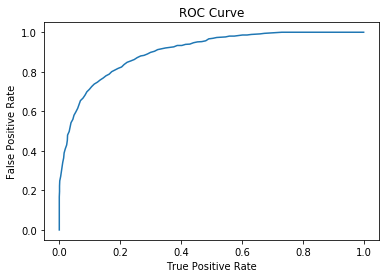

Training set areaUnderROC: 0.902021788502783


In [184]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

We can see the probability of a success/failure by including our features.

In [179]:
pred_test.select('titleType','numVotes','runTimeMinutes','genres', 'Success','prediction', 'probability').show(50)

+---------+--------+--------------+-------------+-------+----------+--------------------+
|titleType|numVotes|runTimeMinutes|       genres|Success|prediction|         probability|
+---------+--------+--------------+-------------+-------+----------+--------------------+
|    movie|   441.0|            78|        Drama|      0|       0.0|[0.82291682553622...|
|    movie|   585.0|            90|        Drama|      0|       0.0|[0.72966698771529...|
|    movie|   290.0|            98|        Drama|      0|       0.0|[0.69987410259675...|
|    movie|  2293.0|           100|        Drama|      0|       0.0|[0.73743796965920...|
|    movie|   789.0|           106|        Drama|      0|       0.0|[0.77741545603628...|
|    movie|   270.0|           106|        Drama|      0|       0.0|[0.67796490943905...|
|    movie|   464.0|            85|        Drama|      0|       0.0|[0.73122953424152...|
|    movie|   772.0|            87|        Drama|      0|       0.0|[0.81201396509627...|
|    movie

Evaluate our model on the training and test sets

In [156]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Training Data Area Under ROC', evaluator.evaluate(pred_train))
print('Testing Data Area Under ROC', evaluator.evaluate(pred_test))

Training Data Area Under ROC 0.9021086939117737
Testing Data Area Under ROC 0.7422534410486209


Confusion Matrix Terms

True Positive (TP): Correctly predicted to be a positive class.
False Positive (FP): Incorrectly predicted to be a positive class.
True Negative (TN): Correctly predicted to not be a positive class.
False Negative (FN): Incorrectly predicted to not be a positive class.

In [172]:
label_pred_test = pred_test.select('label', 'prediction')
label_pred_test.rdd.zipWithIndex().countByKey()

defaultdict(int,
            {Row(label=0.0, prediction=0.0): 469,
             Row(label=0.0, prediction=1.0): 112,
             Row(label=1.0, prediction=0.0): 135,
             Row(label=1.0, prediction=1.0): 198})

In [175]:
Recall = 198/(198+135)
Accuracy =  (198+469)/(198+469+112+135)
Precision = 198/(198+112)

In [176]:
print ('Recall',Recall)
print ('Accuracy', Accuracy)
print ('Precision', Precision)

Recall 0.5945945945945946
Accuracy 0.7297592997811816
Precision 0.6387096774193548


Based on the results, it looks like our model has performed fairly well with the Logistic Regression model.

Now let's try to use the Random Forest classifier to see if we can get a better model!

In [157]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
rfpred_train = rfModel.transform(train)
rfpred_test = rfModel.transform(test)

In [180]:
rfpred_test.select('titleType','numVotes','runTimeMinutes','genres', 'Success','prediction', 'probability').show(50)

+---------+--------+--------------+-------------+-------+----------+--------------------+
|titleType|numVotes|runTimeMinutes|       genres|Success|prediction|         probability|
+---------+--------+--------------+-------------+-------+----------+--------------------+
|    movie|   441.0|            78|        Drama|      0|       0.0|[0.69153970823851...|
|    movie|   585.0|            90|        Drama|      0|       0.0|[0.69153970823851...|
|    movie|   290.0|            98|        Drama|      0|       0.0|[0.69153970823851...|
|    movie|  2293.0|           100|        Drama|      0|       0.0|[0.69153970823851...|
|    movie|   789.0|           106|        Drama|      0|       0.0|[0.67952735048602...|
|    movie|   270.0|           106|        Drama|      0|       0.0|[0.67952735048602...|
|    movie|   464.0|            85|        Drama|      0|       0.0|[0.69153970823851...|
|    movie|   772.0|            87|        Drama|      0|       0.0|[0.69153970823851...|
|    movie

In [158]:
print('Train Area Under ROC', evaluator.evaluate(rfpred_train))
print('Test Area Under ROC', evaluator.evaluate(rfpred_test))

Train Area Under ROC 0.7729119527066031
Test Area Under ROC 0.7181854832457242


Generate the confusion matrix to calculate the metrics

In [171]:
label_rfpred_test = rfpred_test.select('label', 'prediction')
label_rfpred_test.rdd.zipWithIndex().countByKey()

defaultdict(int,
            {Row(label=0.0, prediction=0.0): 572,
             Row(label=0.0, prediction=1.0): 9,
             Row(label=1.0, prediction=0.0): 302,
             Row(label=1.0, prediction=1.0): 31})

In [173]:
rfRecall = 31/(31+302)
rfAccuracy =  (572+31)/(572+9+302+31)
rfPrecision = 31/(31+9)

In [174]:
print ('Recall',rfRecall)
print ('Accuracy', rfAccuracy)
print ('Precision', rfPrecision)

Recall 0.09309309309309309
Accuracy 0.6597374179431073
Precision 0.775


Based on the analysis above, we can conclude that the Logistic regression model has performed much better than the Random Forest. The Random forest model has a tendency to overfit the data, and due to the fact that we only have a few thousand observations, it could be probable to conclude that this might not be the best model to deploy. 

The logistic regression has performed much better, based on the metrics shown above.